El objetivo de este cuaderno es encontrar una buena función de distribución para el estadístico de Kolmogorov-Smirnov tal y como lo utilizo en mi tesois; este estadístico probablemente dependerá de los parámetro n y p de la binomial hipotéticamente subyacente, así como del número N de muestras aleatorias extraídas. 

In [1]:
import numpy as np
import scipy.stats as st
import scipy.special as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt

from myutils import *

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', size=16, family='serif')
plt.rc('figure', autolayout=True) # Esto ayuda a que algunas figuras encajen mejor

# Análisis detallado paso a paso

## Definimos los hiperparámetros

In [23]:
N = 100//2*99*20
n = 100
p = 0.06895169133184537

## Generamos los datos Dks

In [24]:
Dks=[]
for t in range(10000):
    exp=np.histogram(st.binom.rvs(n=n,p=p,size=N), bins=n+1, range=(0,n))[0]
    exp=exp/exp.sum()
    Dks.append(max([abs(exp.cumsum()[i]-st.binom.cdf(k=i,n=n,p=p)) for i in range(n+1)]))

    if (t+1)%100==0:
        print(f"{t+1}",end='\r')

## Construimos el histograma

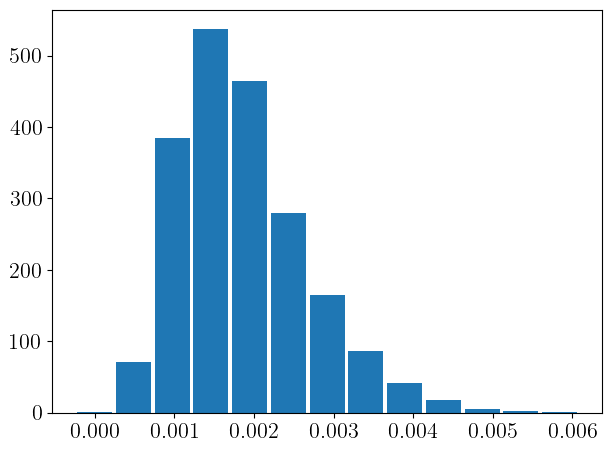

In [25]:
#print(len(get_hist_smooth(Dks,p=0.9)[0]))
hist,bins = np.histogram(Dks, density=True, bins=13, range=(0,max(Dks)))

plt.bar(bins[:-1],hist, width=0.9*(bins[1]-bins[0]))
plt.show()

## Ajustamos el histograma a una curva normal sesgada

a:	3.5570942703264317
loc:	0.0008877905792502254
scale:	0.001243001287113181


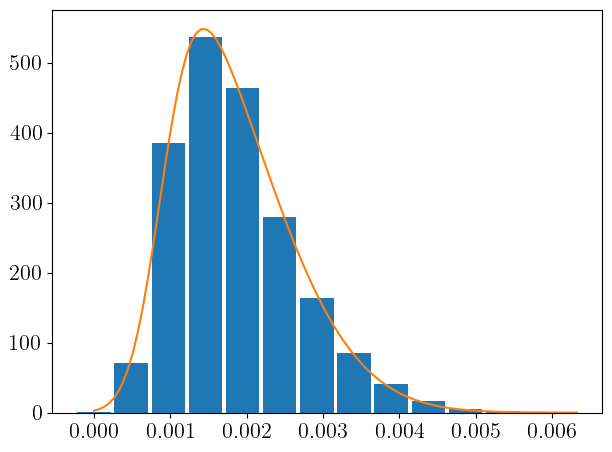

In [26]:
a,loc,scale = opt.curve_fit(st.skewnorm.pdf, xdata=bins[:-1], ydata=hist, p0=[1,1,1])[0]
print(f"a:\t{a}\nloc:\t{loc}\nscale:\t{scale}")

plt.plot(np.linspace(bins[0],bins[-1],100),st.skewnorm.pdf(np.linspace(bins[0],bins[-1],100),a=a,loc=loc,scale=scale),color='C1')
plt.bar(bins[:-1],hist, width=0.9*(bins[1]-bins[0]),color='C0')
plt.show()

## Calculamos el intervalo de confianza (-inf,conf) para las significancias típicas

N: 99000
n: 115
p: 0.06895169133184537

alpha	conf
0.32	0.0021238865626957188
0.05	0.0033240283347253877
0.01	0.004089549718945699
----------------------------------


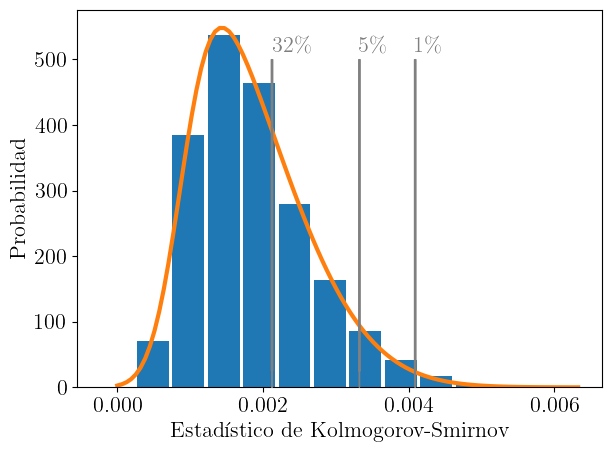

In [27]:
alpha = [1-68/100, 1-95/100, 1-99/100] # Niveles de significancia típicos ("regla empírica").

def func(x,a,loc,scale,alpha):
    return st.skewnorm.cdf(x=x,a=a,loc=loc,scale=scale)-(1-alpha)

conf = [opt.root_scalar(func, args=(a,loc,scale,alpha), bracket=(bins[0],bins[-1]))['root'] for alpha in alpha]

plt.plot(np.linspace(bins[0],bins[-1],100),st.skewnorm.pdf(x=np.linspace(bins[0],bins[-1],100),a=a,loc=loc,scale=scale),color='C1', label="Interpolación",lw=3)
plt.bar(bins[:-1],hist, width=0.9*(bins[1]-bins[0]),color='C0', label="Simulación")
plt.annotate(text=f"$32 \%$", xy=(conf[0],0), xytext=(conf[0],0.95*max(hist)),
             arrowprops=dict(width=1,headwidth=0,color='grey'),color='grey')
plt.annotate(text=f"$5 \%$", xy=(conf[1],0), xytext=(conf[1],0.95*max(hist)),
             arrowprops=dict(width=1,headwidth=0,color='grey'),color='grey')
plt.annotate(text=f"$1 \%$", xy=(conf[2],0), xytext=(conf[2],0.95*max(hist)),
             arrowprops=dict(width=1,headwidth=0,color='grey'),color='grey')
plt.xlabel("Estadístico de Kolmogorov-Smirnov")
plt.ylabel("Probabilidad")
#plt.legend()
#plt.show()
plt.savefig("distribucion-dks.pdf",bbox_inches='tight')

print(f"N: {N}\nn: {n}\np: {p}\n")
print(f"alpha\tconf\n{alpha[0]:.2f}\t{conf[0]}\n{alpha[1]:.2f}\t{conf[1]}\n{alpha[2]:.2f}\t{conf[2]}\n----------------------------------")

## Calculamos el intervalo de confianza entorno a la media para las significancias típicas

In [28]:
print(st.skewnorm.interval(0.68,a=a,loc=loc,scale=scale))
print(st.skewnorm.interval(0.95,a=a,loc=loc,scale=scale))
print(st.skewnorm.interval(0.99,a=a,loc=loc,scale=scale))

(0.0010759709706196123, 0.0026342963196161733)
(0.0006072749205759131, 0.0036738570546021665)
(0.0003450395030363821, 0.004376937166271737)


# Tabla de valores